# Entrenamiento de un modelo convolucional con Data Augmentation
---
### Configuración General del Entorno de Trabajo

Esta sección detecta si el notebook está corriendo en un entorno COLAB o en uno LOCAL . Monta la carpeta de Google Drive si corresponde y define constantes para trabajar de forma general con cualquir script. Modificar las definiciones de las carpetas según el entorno y configuración del mismo.

In [1]:
def entorno_de_trabajo():
    if 'google.colab' in str(get_ipython()): return "colab"  # Colab?
    else: return "local"  # Local => Linux, Windows, WSL

if entorno_de_trabajo() == 'colab': # maquina virtual colab
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = '/content/DATOS/' # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'    # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/'     # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Flujo de trabajo con los datos

Implementamos una estrategia para transferir los datos desde Google Drive (almacenamiento permanente) al sistema de archivos local de Colab (almacenamiento volátil). El archivo Fingers.zip se descomprime en la máquina virtual para evitar los cuellos de botella característicos del acceso recurrente a archivos en Drive, especialmente notable cuando se trabaja con carpetas que contienen numerosos archivos (aunque el tamaño individual no sea grande). Este enfoque acelera significativamente las operaciones de lectura/escritura durante el procesamiento.


In [2]:
import zipfile
import os

# Ruta al archivo ZIP en Google Drive (asumiendo que está en la carpeta Fingers)
zip_path = os.path.join(DATOS_DIR, 'Fingers/Fingers.zip')

# Ruta de destino para la extracción (carpeta local)
extract_dir = LOCAL_DIR

# Verificar si el archivo ZIP existe
if not os.path.exists(zip_path):
    print(f"Error: El archivo {zip_path} no existe.")
else:
    # Crear la carpeta de destino si no existe
    os.makedirs(extract_dir, exist_ok=True)

    # Descomprimir el archivo ZIP
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Archivo descomprimido exitosamente en: {extract_dir}")
    except zipfile.BadZipFile:
        print("Error: El archivo ZIP está corrupto o no es válido.")
    except Exception as e:
        print(f"Ocurrió un error al descomprimir: {str(e)}")

Archivo descomprimido exitosamente en: /content/DATOS/


## Importante

### Preparación de los datos para Data Augmentation

La clase **ImageDataGenerator** genera variantes de las imagenes que componen el dataset. Además, a través de **flow_from_directory** permite asociar la carpeta donde están las imagenes, sin necesidad de cargarlas previamente. Asume que el nombre de las subcarpetas es el nombre de la clase y que las imágenes de dicha clase están dentro.

La clase **ImageDataGenerator** de Keras facilita el trabajo con datasets almacenados en carpetas, el aumento de datos (data augmentation) y el preprocesamiento de imágenes. Su función principal es generar variantes de las imágenes del dataset aplicando transformaciones aleatorias en tiempo real durante el entrenamiento.
Principales características:
* Aumento de datos integrado: Aplica transformaciones aleatorias como rotaciones, volteos, zoom y ajustes de brillo/contraste.
* Normalización automática: Escala los valores de píxeles a rangos estándar (como [0,1] o [-1,1]).
* Preprocesamiento en tiempo real: Las transformaciones se aplican sobre la marcha, sin necesidad de almacenar múltiples versiones de cada imagen.

El método **flow_from_directory** de **ImageDataGenerator** complementa al generador permitiendo:
* Cargar imágenes directamente desde una estructura de directorios organizada por clases.
* Asociar automáticamente cada imagen con su etiqueta según la subcarpeta donde se encuentra. Estructura de directorios requerida:
```plaintext
    directorio_dataset/
    │
    ├── clase_1/
    │   ├── imagen1.jpg
    │   ├── imagen2.jpg
    │   └── ...
    ├── clase_2/
    │   ├── imagen1.jpg
    │   └── ...
    └── ...
```
* Generar lotes de datos aumentados sobre la marcha, sin cargar todo el dataset en memoria.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, InputLayer, Conv2D, MaxPooling2D, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = (64, 64, 1)
N_CLASSES = 6
LOTES  = 64

# construye un generador de imagenes para dividir en entrenamiento y validación
# aplicando transformaciones para aumentar los datos
data_train_generator = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=60,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    # vertical_flip=False,     # espejo vertical
    fill_mode="reflect" # rellena los bordes reflejando la imagen para que no se tomen como un patrón
    )

# generador para entrenamiento a partir de la carpeta indicada
train_iter = data_train_generator.flow_from_directory( # Para recuperar las imagenes de la carpeta
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=LOCAL_DIR+'Fingers/train', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot, va a ir a buscar las subcarpetas y el nombre de cada una lo toma como etiqueta
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='training'                    # asigna subconjunto por validation_split del ImageDataGenerator
            )

valid_iter = data_train_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=LOCAL_DIR+'Fingers/train', # carpeta de datos
            class_mode='categorical',            # utiliza codificacion one-hot
            batch_size=LOTES,                    # Tamaño del lote
            color_mode='grayscale',              # aplica transformación
            subset='validation'                  # asigna subconjunto por validation_split del ImageDataGenerator
            )


data_test_generator = ImageDataGenerator(
    rotation_range=60,         # rotacion
    rescale=1./255,            # escalado [0,1]
    # zoom_range=0.15,         # zoom
    # width_shift_range=0.1,   # desplazamiento horizontal
    # height_shift_range=0.1,  # desplazamiento vertical
    # shear_range=0.15,        #
    # horizontal_flip=False,   # espejo horizontal
    #vertical_flip=False,      # espejo vertical
    fill_mode="reflect"
    )

test_iter = data_test_generator.flow_from_directory(
            target_size=(IMG_SIZE[0],IMG_SIZE[1]),
            directory=LOCAL_DIR+'Fingers/test',     # carpeta de datos
            class_mode='categorical',               # utiliza codificacion one-hot
            color_mode='grayscale',                 # aplica transformación
            batch_size=LOTES                        # Tamaño del lote
            )

Found 14400 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.
Found 3600 images belonging to 6 classes.


### Muestra de algunas imagenes de la carpeta de entrenamiento utilizando el iterador

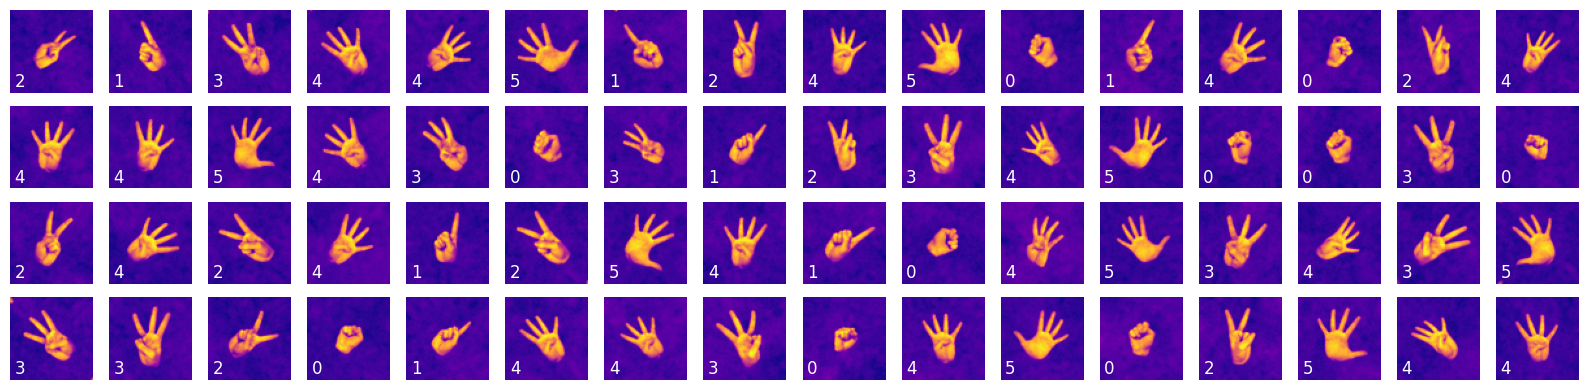

In [15]:
imágenes, etiquetas = next(train_iter)  # Extrae un lote de imágenes y etiquetas

COLOR_MAP = 'plasma'   #@param ['viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray']
filas = 4              #@param {type: "slider", min: 1, max: 10, step: 1}
columnas = 16          #@param {type: "slider", min: 8, max: 20, step: 2}

# Configuración de la grilla para dibujar imagenes
fig, axes = plt.subplots(filas, columnas, figsize=(columnas, filas))

# Itera sobre las imágenes del lote
for idx in range(min(filas * columnas, len(imágenes))):
    imagen = imágenes[idx].squeeze()      # Elimina dimensiones extra si es necesario
    etiqueta = np.argmax(etiquetas[idx])  # Obtiene etiqueta: one-hot -> indice donde aparece el 1

    (i, j) = (idx // columnas, idx % columnas) # Calcula la posición de la imagen en la grilla

    # grafica imagen con etiqueta en el borde inferior izquierdo
    axes[i, j].imshow(imagen, cmap=COLOR_MAP)
    axes[i, j].text(3, 59, str(etiqueta), color='white', fontsize=12, backgroundcolor='none')  # Etiqueta en esquina inferior izquierda
    axes[i, j].axis('off')  # Oculta los ejes

plt.tight_layout()
plt.show()

### Construcción y entrenamiento del modelo
Estee ejemplo utiliza LeakyReLU como activación. Puede pasarse como parámetro **activation** de una capa Dense o Conv2D u omitirse y agregarse como capa independendiente. Si bien el funcioamiento es igual, para almacenar el modelo y poder recuperarlo es mejor agregarla como capa independiente.

In [16]:
EPOCAS = 50
LOTES  = 128
PACIENCIA=4

FN_ACTIVA = LeakyReLU()

# Construye el modelo
model = Sequential()

model.add(Input(shape=IMG_SIZE))
model.add(Conv2D(16, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(FN_ACTIVA)
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='same', activation=FN_ACTIVA))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(64, activation = FN_ACTIVA))
model.add(Dense(N_CLASSES, activation = 'softmax'))

model.summary()

# construye el modelo
optimizer = 'Adam' #optimizers.Adam(0.001)
model.compile(optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])


# parada temprana para evitar el sobreajuste
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=PACIENCIA, restore_best_weights=True)

H = model.fit(
    train_iter,
    validation_data=valid_iter,
    epochs=EPOCAS,
    callbacks=[early_stop],
    verbose=1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,542 (2.02 MB)

 Trainable params: 529,542 (2.02 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.6695 - loss: 0.8850 - val_accuracy: 0.9867 - val_loss: 0.0631
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 80ms/step - accuracy: 0.9858 - loss: 0.0543 - val_accuracy: 0.9778 - val_loss: 0.0648
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 72ms/step - accuracy: 0.9926 - loss: 0.0257 - val_accuracy: 1.0000 - val_loss: 0.0075
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9991 - loss: 0.0072 - val_accuracy: 0.9997 - val_loss: 0.0028
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9991 - loss: 0.0050 - val_accuracy: 0.9967 - val_loss: 0.0091
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.9994 - val_loss: 0.0019
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 66ms/step - accuracy: 0.9995 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 5.3818e-04
Epoch 8/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 16s 69ms/step - accuracy: 0.9994 - loss: 0.0021 - val_acc

### Graficas y métricas de la evolución del modelo


Efectividad del modelo con datos de entrenamiento: 100.00%
Efectividad del modelo con datos de Validación...: 100.00%
Efectividad del modelo con datos de Prueba.......: 100.00%


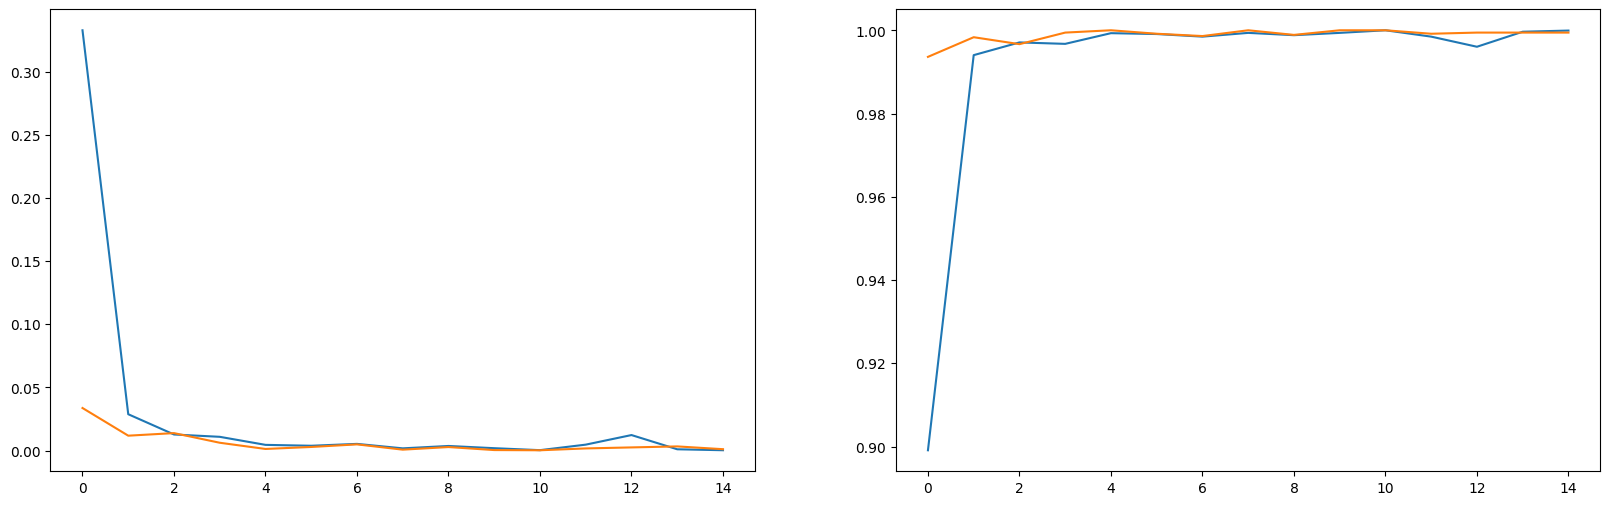

In [6]:
# dibuja accuracy del progreso del entrenamiento
fig, axs = plt.subplots(1,2, figsize=(20,6))

axs[0].plot(H.history["loss"], label="train_loss")
axs[0].plot(H.history["val_loss"], label="val_loss")

axs[1].plot(H.history["accuracy"], label="train_acc")
axs[1].plot(H.history["val_accuracy"], label="val_acc")

# %% evalua el modelo para entrenamiento
pred = model.evaluate(train_iter, verbose=0)
print("\nEfectividad del modelo con datos de entrenamiento: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de testeo
pred = model.evaluate(valid_iter, verbose=0)
print("Efectividad del modelo con datos de Validación...: %6.2f%%" % (pred[1]*100))

# evalua el modelo con los datos de testeo
pred = model.evaluate(test_iter, verbose=0)
print("Efectividad del modelo con datos de Prueba.......: %6.2f%%" % (pred[1]*100))



Efectividad del modelo con datos de Prueba rotado   0 grados: 100.00%
Efectividad del modelo con datos de Prueba rotado   5 grados: 100.00%
Efectividad del modelo con datos de Prueba rotado  10 grados: 100.00%
Efectividad del modelo con datos de Prueba rotado  15 grados:  98.44%
Efectividad del modelo con datos de Prueba rotado  20 grados:  96.88%
Efectividad del modelo con datos de Prueba rotado  25 grados:  95.31%
Efectividad del modelo con datos de Prueba rotado  30 grados:  95.31%
Efectividad del modelo con datos de Prueba rotado  35 grados:  98.44%
Efectividad del modelo con datos de Prueba rotado  40 grados:  93.75%
Efectividad del modelo con datos de Prueba rotado  45 grados:  93.75%
Efectividad del modelo con datos de Prueba rotado  50 grados:  92.19%
Efectividad del modelo con datos de Prueba rotado  55 grados:  87.50%
Efectividad del modelo con datos de Prueba rotado  60 grados:  84.38%
Efectividad del modelo con datos de Prueba rotado  65 grados:  76.56%
Efectividad del mode

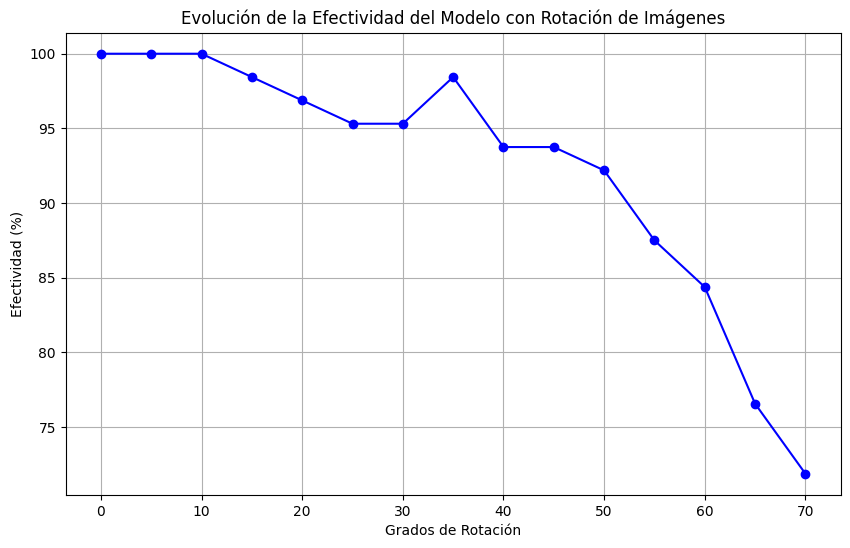

In [13]:
from skimage.transform import rotate

def rotar_grados(data_imgs, ang):
    result = np.empty_like(data_imgs)
    for i, img in enumerate(data_imgs):
        result[i] = rotate(img, ang, resize=False, mode='reflect')
    return result

batch_images, batch_labels = next(test_iter)

# Lista para almacenar los resultados de la efectividad
efectividades = []
grados_rotacion = []

for i in range(15):
    grados = i * 5
    x_test_rot = rotar_grados(batch_images, grados)

    # Evalúa el modelo con los datos de prueba rotados
    pred = model.evaluate(x_test_rot, batch_labels, verbose=0)
    efectividad = pred[1] * 100
    print("Efectividad del modelo con datos de Prueba rotado %3d grados: %6.2f%%" % (grados, efectividad))

    # Almacena los resultados
    efectividades.append(efectividad)
    grados_rotacion.append(grados)

# Crea el gráfico
plt.figure(figsize=(10, 6))
plt.plot(grados_rotacion, efectividades, marker='o', linestyle='-', color='b')
plt.title('Evolución de la Efectividad del Modelo con Rotación de Imágenes')
plt.xlabel('Grados de Rotación')
plt.ylabel('Efectividad (%)')
plt.grid(True)
plt.show()